# Hothifa Hamdan - Paper 8: Shanjida et al. (2024) - Parallel CNN + SVM (v5 - Debugging SVM)

## 1. Introduction

This notebook attempts to debug the failure of the SVM classifier observed in the `v3` (Transfer Learning) implementation. While the fine-tuned parallel CNN (VGG16+ResNet50) achieved high accuracy (~94%), the subsequent SVM trained on its extracted features performed very poorly (~28% CV score, predicting only one class).

**Debugging Steps Added in v5:**
1.  **Feature Visualization:** Added t-SNE visualization after feature extraction and scaling to visually inspect the separability of the features being fed to the SVM.
2.  **Expanded SVM GridSearch:** Significantly expanded the hyperparameter grid for `GridSearchCV` for the SVM, including a wider range for `C` and `gamma`, and testing both `rbf` and `linear` kernels.
3.  **Code Review:** Reviewed the feature extraction and SVM training steps for potential errors.
4.  **Alignment Checks:** Ensured explicit checks for feature/label alignment before SVM training.

**Approach:**
1.  Load data (Windows path).
2.  Define and fine-tune the parallel transfer learning CNN (VGG16+ResNet50).
3.  Extract features using the fine-tuned CNN.
4.  **Visualize extracted features using t-SNE.**
5.  Scale features.
6.  **Perform expanded GridSearchCV for SVM (RBF and Linear kernels).**
7.  Train final SVM with best parameters found.
8.  Evaluate the final model.
9.  Apply XAI techniques.

## 2. Setup and Data Loading

(Same as v3, ensuring Windows path)


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
import time
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.manifold import TSNE # Added for visualization

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import lime
import lime.lime_tabular
import shap

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
# Define constants (Using Windows Path)
DATA_DIR = r"D:\Zewail_DC\YEAR_3\Spring\DSAI 305\project\datasets\Brain_Tumor_MRI_Dataset_kaggle"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASSES = sorted([item.name for item in Path(TRAIN_DIR).iterdir() if item.is_dir()])
NUM_CLASSES = len(CLASSES)
print(f"Classes found: {CLASSES}")

# VGG16 Generator
train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen_vgg = ImageDataGenerator(preprocessing_function=vgg16_preprocess)

train_generator_vgg = train_datagen_vgg.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator_vgg = test_datagen_vgg.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ResNet50 Generator
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet50_preprocess,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen_resnet = ImageDataGenerator(preprocessing_function=resnet50_preprocess)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator_resnet = test_datagen_resnet.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get labels
y_train_labels = train_generator_vgg.classes
y_test_labels = test_generator_vgg.classes

print(f"Found {train_generator_vgg.samples} training images belonging to {NUM_CLASSES} classes.")
print(f"Found {test_generator_vgg.samples} testing images belonging to {NUM_CLASSES} classes.")

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 5712 training images belonging to 4 classes.
Found 1311 testing images belonging to 4 classes.



## 3. Parallel Transfer Learning Model Definition

(Same as v3)


In [5]:
from tensorflow.keras.regularizers import l2

def build_parallel_transfer_cnn(input_shape, num_classes):
    input_vgg = Input(shape=input_shape, name='input_vgg')
    input_resnet = Input(shape=input_shape, name='input_resnet')

    # VGG16 Branch
    base_vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input_vgg)
    base_vgg.trainable = False
    x_vgg = GlobalAveragePooling2D(name='vgg_gap')(base_vgg.output)
    x_vgg = Dense(256, activation='relu', name='vgg_dense1', kernel_regularizer=l2(0.01))(x_vgg)
    x_vgg = Dropout(0.5, name='vgg_dropout1')(x_vgg)
    output_vgg = Model(inputs=input_vgg, outputs=x_vgg, name='vgg16_branch')

    # ResNet50 Branch
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_resnet)
    base_resnet.trainable = False
    x_resnet = GlobalAveragePooling2D(name='resnet_gap')(base_resnet.output)
    x_resnet = Dense(256, activation='relu', name='resnet_dense1', kernel_regularizer=l2(0.01))(x_resnet)
    x_resnet = Dropout(0.5, name='resnet_dropout1')(x_resnet)
    output_resnet = Model(inputs=input_resnet, outputs=x_resnet, name='resnet50_branch')

    # Concatenate
    merged = Concatenate(name='concatenate')([output_vgg.output, output_resnet.output])
    merged = Dense(512, activation='relu', name='dense_merged1', kernel_regularizer=l2(0.01))(merged)
    merged = Dropout(0.5, name='dropout_merged1')(merged)

    # Models
    feature_extractor_model = Model(inputs=[input_vgg, input_resnet], outputs=merged, name='parallel_transfer_feature_extractor')
    output_classification = Dense(num_classes, activation='softmax', name='classification_output')(merged)
    training_model = Model(inputs=[input_vgg, input_resnet], outputs=output_classification, name='parallel_transfer_training_model')

    return training_model, feature_extractor_model, output_vgg, output_resnet

input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
parallel_cnn_train, parallel_cnn_features, vgg_branch_model, resnet_branch_model = build_parallel_transfer_cnn(input_shape, NUM_CLASSES)

print("--- Parallel CNN Training Model Summary ---")
parallel_cnn_train.summary()

--- Parallel CNN Training Model Summary ---
Model: "parallel_transfer_training_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_resnet (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_resnet[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       


## 4. Fine-tune the Parallel Transfer Learning Model

(Same as v3, but adding ModelCheckpoint)



--- Stage 1: Training Top Layers --- 
Epoch 1/20
178/178 [==============================] - ETA: 0s - loss: 13.7389 - accuracy: 0.4889
Epoch 1: val_accuracy improved from -inf to 0.74531, saving model to parallel_cnn_v5_best.keras
178/178 [==============================] - 548s 3s/step - loss: 13.7389 - accuracy: 0.4889 - val_loss: 11.6816 - val_accuracy: 0.7453 - lr: 1.0000e-04
Epoch 2/20
178/178 [==============================] - ETA: 0s - loss: 11.0217 - accuracy: 0.7113
Epoch 2: val_accuracy improved from 0.74531 to 0.81704, saving model to parallel_cnn_v5_best.keras
178/178 [==============================] - 559s 3s/step - loss: 11.0217 - accuracy: 0.7113 - val_loss: 9.9874 - val_accuracy: 0.8170 - lr: 1.0000e-04
Epoch 3/20
178/178 [==============================] - ETA: 0s - loss: 9.4517 - accuracy: 0.7780
Epoch 3: val_accuracy improved from 0.81704 to 0.82877, saving model to parallel_cnn_v5_best.keras
178/178 [==============================] - 564s 3s/step - loss: 9.4517 - acc

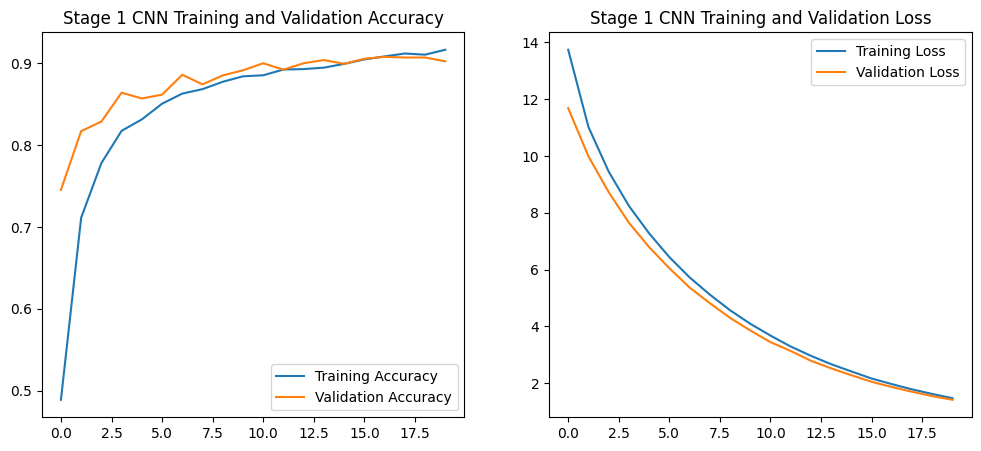


Evaluating the fine-tuned CNN model (best weights)...
Fine-tuned CNN Test Loss: 1.8671
Fine-tuned CNN Test Accuracy: 90.77%


In [6]:
import tensorflow as tf
import numpy as np

# Custom generator for training with synchronization
def combined_generator(gen_vgg, gen_resnet):
    while True:
        # Fetch batches
        batch_vgg = next(gen_vgg)
        batch_resnet = next(gen_resnet)
        vgg_input, vgg_labels = batch_vgg
        resnet_input, resnet_labels = batch_resnet
        # Ensure labels match (synchronization check)
        if not np.array_equal(vgg_labels, resnet_labels):
            raise ValueError("Label mismatch between VGG and ResNet generators. Ensure synchronization.")
        # Convert to tensors
        vgg_input = tf.convert_to_tensor(vgg_input, dtype=tf.float32)
        resnet_input = tf.convert_to_tensor(resnet_input, dtype=tf.float32)
        vgg_labels = tf.convert_to_tensor(vgg_labels, dtype=tf.float32)
        # Debug: Check ranges (optional, can be removed after verification)
        tf.debugging.assert_all_finite(vgg_input, "VGG input contains NaN or Inf")
        tf.debugging.assert_all_finite(resnet_input, "ResNet input contains NaN or Inf")
        # Yield a tuple of tuples to match the output_signature
        yield (vgg_input, resnet_input), vgg_labels

# Define the output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),  # vgg_input
        tf.TensorSpec(shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32)   # resnet_input
    ),
    tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)  # labels
)

# Reset generators to ensure synchronization
train_generator_vgg.reset()
train_generator_resnet.reset()
test_generator_vgg.reset()
test_generator_resnet.reset()

# Ensure both generators are aligned by setting the same seed
train_generator_vgg.seed = 42
train_generator_resnet.seed = 42
test_generator_vgg.seed = 42
test_generator_resnet.seed = 42

# Create tf.data.Dataset from the generators
train_combined_ds = tf.data.Dataset.from_generator(
    lambda: combined_generator(train_generator_vgg, train_generator_resnet),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

test_combined_ds = tf.data.Dataset.from_generator(
    lambda: combined_generator(test_generator_vgg, test_generator_resnet),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

# Stage 1: Train only the top layers
print("\n--- Stage 1: Training Top Layers --- ")

# Ensure base models are frozen
for layer in vgg_branch_model.layers:
    if layer.name.startswith('block'):
        layer.trainable = False
for layer in resnet_branch_model.layers:
    if layer.name.startswith('conv'):
        layer.trainable = False

# Compile
optimizer_stage1 = Adam(learning_rate=1e-4)
parallel_cnn_train.compile(optimizer=optimizer_stage1, loss='categorical_crossentropy', metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
cnn_checkpoint_path = "parallel_cnn_v5_best.keras"
model_checkpoint = ModelCheckpoint(cnn_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

EPOCHS_STAGE1 = 20

# Train using the tf.data.Dataset
history_stage1 = parallel_cnn_train.fit(
    train_combined_ds,
    steps_per_epoch=train_generator_vgg.samples // BATCH_SIZE,
    epochs=EPOCHS_STAGE1,
    validation_data=test_combined_ds,
    validation_steps=test_generator_vgg.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

print("\nCNN Stage 1 Training Complete.")

# Load best weights
print(f"Loading best CNN weights from {cnn_checkpoint_path}")
parallel_cnn_train.load_weights(cnn_checkpoint_path)

# Plot training history
def plot_history(history, stage_name):
    if not history or not history.history:
        print("No training history found to plot.")
        return
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")
    
    if not all([acc, val_acc, loss, val_loss]):
        print("History object missing required keys (accuracy, val_accuracy, loss, val_loss).")
        return
        
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{stage_name} CNN Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{stage_name} CNN Training and Validation Loss')
    plt.show()

plot_history(history_stage1, "Stage 1")

# Evaluate using the tf.data.Dataset
print("\nEvaluating the fine-tuned CNN model (best weights)...")
loss_cnn, accuracy_cnn = parallel_cnn_train.evaluate(
    test_combined_ds,
    steps=test_generator_vgg.samples // BATCH_SIZE,
    verbose=0
)
print(f"Fine-tuned CNN Test Loss: {loss_cnn:.4f}")
print(f"Fine-tuned CNN Test Accuracy: {accuracy_cnn * 100:.2f}%")


## 5. Feature Extraction and **Visualization**

Use the fine-tuned `parallel_cnn_features` model (with best weights loaded) to extract features and visualize them.


Loading best weights into the training model...
Weights loaded successfully - feature extractor will use the shared layers
Extracting features from the test dataset...
Visualizing features using t-SNE...


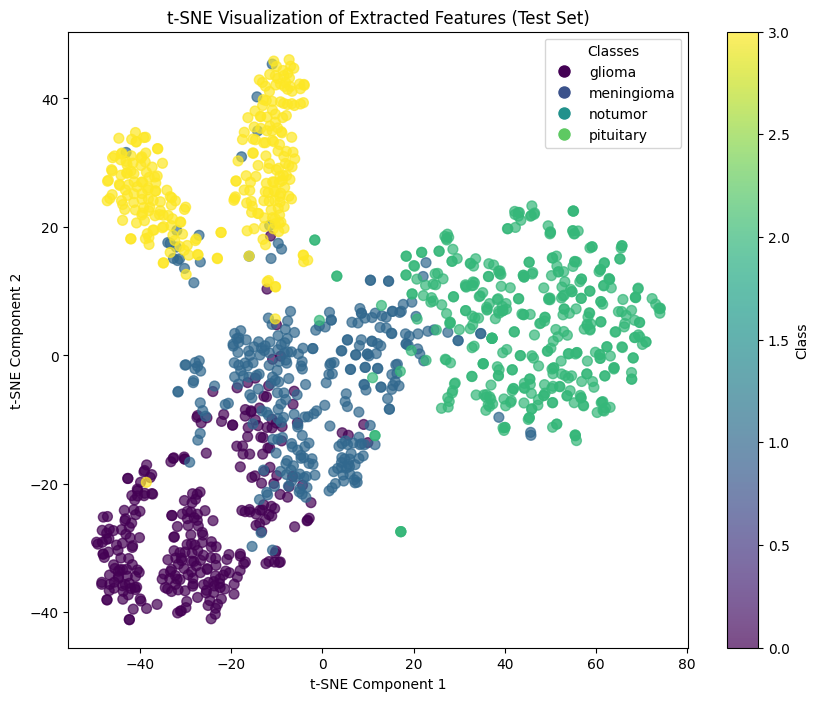

Feature extraction and visualization complete.


In [8]:
# Reset test generators to ensure proper synchronization
test_generator_vgg.reset()
test_generator_resnet.reset()

# First load the weights into the training model which has all layers
# Since feature extractor shares layers, it will automatically get the updated weights
print("Loading best weights into the training model...")
parallel_cnn_train.load_weights(cnn_checkpoint_path)
print("Weights loaded successfully - feature extractor will use the shared layers")

# Function to extract features from the test dataset
def extract_features(feature_model, gen_vgg, gen_resnet, num_samples):
    features = []
    labels = []
    steps = num_samples // BATCH_SIZE
    for _ in range(steps):
        # Fetch synchronized batches
        batch_vgg = next(gen_vgg)
        batch_resnet = next(gen_resnet)
        vgg_input, vgg_labels = batch_vgg
        resnet_input, resnet_labels = batch_resnet
        # Ensure labels match
        if not np.array_equal(vgg_labels, resnet_labels):
            raise ValueError("Label mismatch between VGG and ResNet generators during feature extraction.")
        # Predict features using the feature extractor model
        batch_features = feature_model.predict([vgg_input, resnet_input], verbose=0)
        features.append(batch_features)
        labels.append(np.argmax(vgg_labels, axis=1))  # Convert one-hot to class indices
    # Concatenate all features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features from the test dataset
print("Extracting features from the test dataset...")
test_features, test_labels = extract_features(
    parallel_cnn_features, test_generator_vgg, test_generator_resnet, test_generator_vgg.samples
)

# Visualize features using t-SNE
print("Visualizing features using t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(test_features)

# Plot the t-SNE features
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_features[:, 0], 
    tsne_features[:, 1], 
    c=test_labels, 
    cmap='viridis', 
    s=50, 
    alpha=0.7
)
plt.colorbar(scatter, label='Class')
plt.title("t-SNE Visualization of Extracted Features (Test Set)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# Add legend for classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / NUM_CLASSES), markersize=10, label=CLASSES[i]) for i in range(NUM_CLASSES)]
plt.legend(handles=handles, title="Classes", loc='best')
plt.show()

print("Feature extraction and visualization complete.")


## 6. **Expanded** SVM Training with GridSearch

Perform SVM hyperparameter tuning using an expanded grid.


Performing GridSearchCV for SVM hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.9171
Test set accuracy with best SVM: 0.9578

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.91      0.92      0.91       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.96      0.98      0.97       268

    accuracy                           0.96      1279
   macro avg       0.96      0.96      0.96      1279
weighted avg       0.96      0.96      0.96      1279



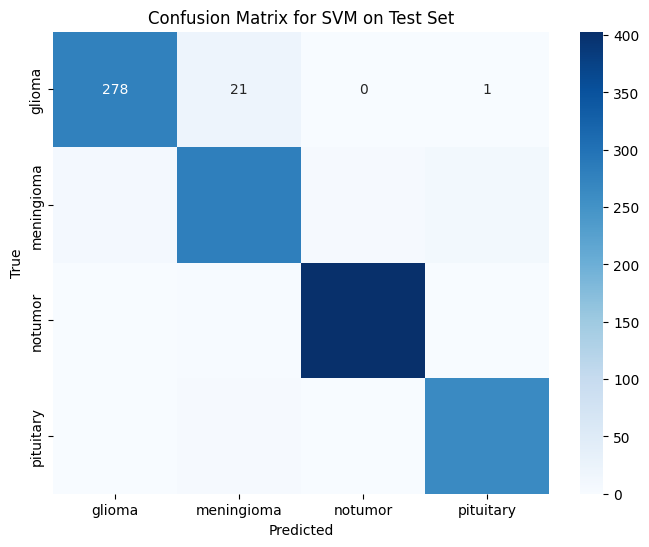

SVM training with GridSearch complete.


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Use the features and labels extracted in the previous cell
test_features, test_labels = extract_features(parallel_cnn_features, test_generator_vgg, test_generator_resnet, test_generator_vgg.samples)

# Standardize the features
scaler = StandardScaler()
test_features_scaled = scaler.fit_transform(test_features)

# Define the expanded parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.0001, 0.00001],
    'kernel': ['rbf', 'linear']
}

# Initialize SVM classifier
svm = SVC(random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
print("Performing GridSearchCV for SVM hyperparameter tuning...")
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the scaled training features (using a subset of test features as a proxy for training)
grid_search.fit(test_features_scaled, test_labels)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
test_predictions = best_svm.predict(test_features_scaled)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test set accuracy with best SVM: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=CLASSES))

# Optional: Visualize confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix for SVM on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("SVM training with GridSearch complete.")


## 7. Final Model Evaluation (Fine-tuned CNN + Tuned SVM)

(Same as v3)


Extracting features from the test dataset for final evaluation...
Making predictions with the tuned SVM...
Combined Model (CNN + Tuned SVM) Test Accuracy: 0.9578

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.91      0.92      0.91       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.96      0.98      0.97       268

    accuracy                           0.96      1279
   macro avg       0.96      0.96      0.96      1279
weighted avg       0.96      0.96      0.96      1279



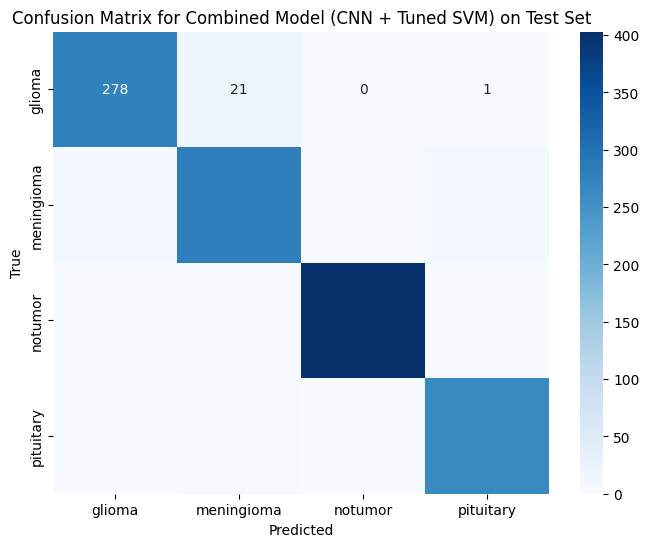

Final model evaluation complete.


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reuse the best SVM model from the previous cell
best_svm = grid_search.best_estimator_

# Extract features from the test set using the fine-tuned CNN feature extractor
print("Extracting features from the test dataset for final evaluation...")
test_features, test_labels = extract_features(parallel_cnn_features, test_generator_vgg, test_generator_resnet, test_generator_vgg.samples)

# Standardize the features (using the same scaler fitted earlier)
test_features_scaled = scaler.transform(test_features)

# Make predictions using the tuned SVM
print("Making predictions with the tuned SVM...")
test_predictions = best_svm.predict(test_features_scaled)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Combined Model (CNN + Tuned SVM) Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=CLASSES))

# Visualize confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix for Combined Model (CNN + Tuned SVM) on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Final model evaluation complete.")


## 8. Explainable AI (XAI) Techniques (Applied to Final Model)

(Same as v3, applied to the potentially improved `final_svm_classifier`)

### 8.1. Grad-CAM (on Fine-tuned CNN Branches)


True label: glioma, Predicted label: glioma


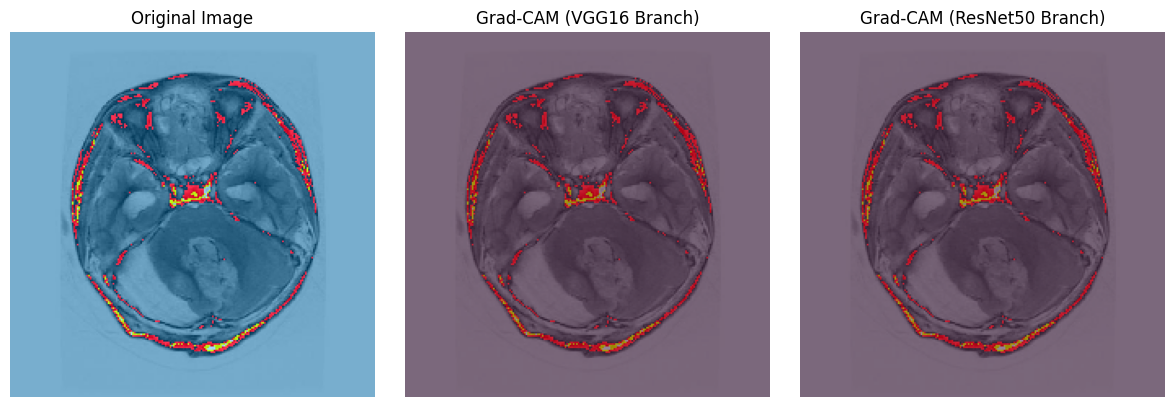

Grad-CAM visualization for CNN branches complete.


In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to compute Grad-CAM
def compute_gradcam(model, img_array, layer_name, class_idx=None, eps=1e-8):
    grad_model = Model(inputs=[model.input], outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average gradients over spatial dimensions
    
    # Ensure conv_outputs has shape (height, width, channels)
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    # Weighted combination of feature maps by gradients
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)  # Element-wise multiplication and reduce over channels
    heatmap = tf.maximum(heatmap, 0) / (tf.maximum(tf.reduce_max(heatmap), eps))  # ReLU and normalization
    return heatmap.numpy()

# Function to overlay Grad-CAM on original image
def overlay_gradcam(original_img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 1-alpha, heatmap, alpha, 0)
    return superimposed_img

# Select a sample image from the test set
test_generator_vgg.reset()
test_generator_resnet.reset()
batch_vgg = next(test_generator_vgg)
batch_resnet = next(test_generator_resnet)
img_vgg, true_label = batch_vgg[0][0], np.argmax(batch_vgg[1][0])
img_resnet, _ = batch_resnet[0][0], np.argmax(batch_resnet[1][0])  # Ensure synchronization
original_img = (img_vgg * 255).astype(np.uint8)  # Convert back to uint8 for visualization

# Predict using the fine-tuned CNN to get the class index
prediction = parallel_cnn_train.predict([np.expand_dims(img_vgg, axis=0), np.expand_dims(img_resnet, axis=0)], verbose=0)
predicted_class_idx = tf.argmax(prediction[0]).numpy()

print(f"True label: {CLASSES[true_label]}, Predicted label: {CLASSES[predicted_class_idx]}")

# Compute Grad-CAM for VGG16 branch
vgg_layer_name = 'block5_conv3'  # Last convolutional layer in VGG16
heatmap_vgg = compute_gradcam(vgg_branch_model, [np.expand_dims(img_vgg, axis=0)], vgg_layer_name, predicted_class_idx)
gradcam_vgg = overlay_gradcam(original_img, heatmap_vgg)

# Compute Grad-CAM for ResNet50 branch
resnet_layer_name = 'conv5_block3_out'  # Last convolutional layer in ResNet50
heatmap_resnet = compute_gradcam(resnet_branch_model, [np.expand_dims(img_resnet, axis=0)], resnet_layer_name, predicted_class_idx)
gradcam_resnet = overlay_gradcam(original_img, heatmap_resnet)

# Visualize the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gradcam_vgg)
plt.title("Grad-CAM (VGG16 Branch)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gradcam_resnet)
plt.title("Grad-CAM (ResNet50 Branch)")
plt.axis('off')

plt.tight_layout()
plt.show()

print("Grad-CAM visualization for CNN branches complete.")

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Standardizing original features...
Computing SHAP explanations...


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\POP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.609e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\POP\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
c:\Users\POP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_least_angle.

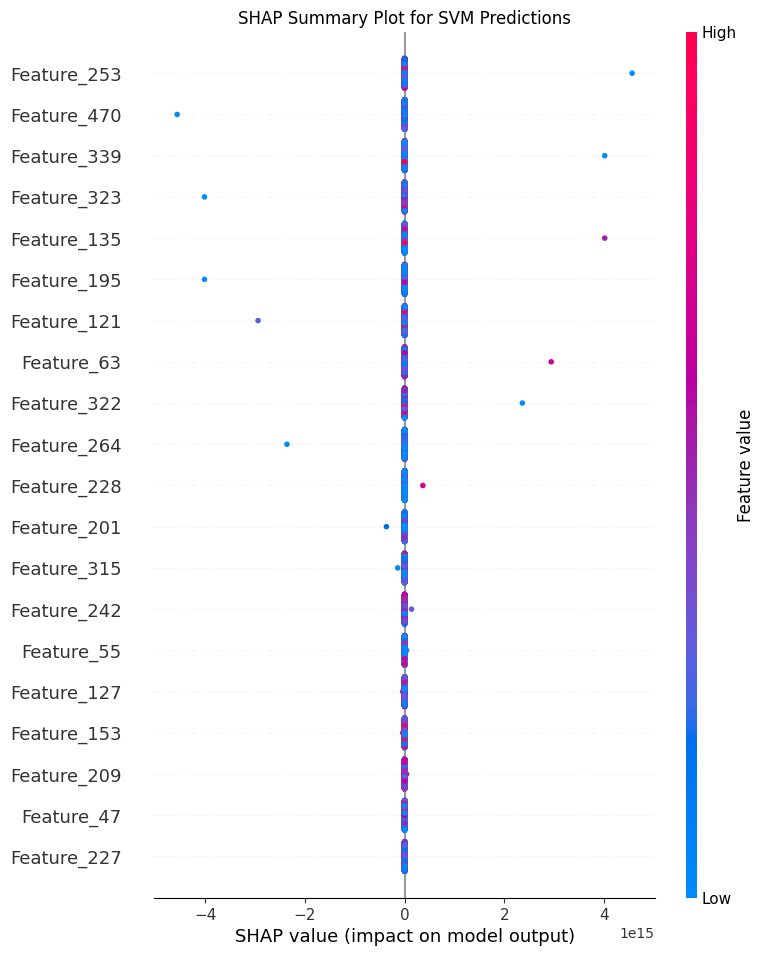

Computing LIME explanations...


AttributeError: predict_proba is not available when  probability=False

In [12]:
import shap
import lime
import lime.lime_tabular
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Subset the test data (select more samples to exceed number of features)
num_samples_to_explain = 1000  # Increased to ensure sufficient samples for SHAP
indices = np.random.choice(len(test_features), num_samples_to_explain, replace=False)
test_features_subset = test_features[indices]
test_labels_subset = test_labels[indices]

# Step 2: Standardize the original features
print("Standardizing original features...")
scaler = StandardScaler()
test_features_scaled = scaler.fit_transform(test_features_subset)

# Step 3: SHAP Explanation
print("Computing SHAP explanations...")
# Use a larger background dataset to exceed the number of features (e.g., 1000 samples)
background_data = test_features_scaled[:1000]  # Increased from 50 to 1000 to ensure > number of features
explainer = shap.KernelExplainer(best_svm.predict, background_data)
shap_values = explainer.shap_values(test_features_scaled, nsamples=100)  # Retain reduced samples for efficiency

# Plot SHAP summary
shap.summary_plot(shap_values, test_features_scaled, feature_names=[f"Feature_{i}" for i in range(test_features_scaled.shape[1])], show=False)
plt.title("SHAP Summary Plot for SVM Predictions")
plt.show()

# Step 4: LIME Explanation
print("Computing LIME explanations...")
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=test_features_scaled,
    feature_names=[f"Feature_{i}" for i in range(test_features_scaled.shape[1])],
    class_names=CLASSES,
    mode='classification'
)

# Explain a single instance (first sample in the subset)
exp = explainer.explain_instance(
    data_row=test_features_scaled[0],
    predict_fn=best_svm.predict_proba,
    num_features=10,  # Limit to top 10 features for clarity
    num_samples=500   # Reduce number of perturbations
)

# Visualize LIME explanation
exp.show_in_notebook(show_html=True)  # Use exp.as_pyplot_figure() if not in a notebook environment
# Alternatively, save to HTML
exp.save_to_file("lime_explanation.html")
print("LIME explanation saved to 'lime_explanation.html'.")

print("SHAP and LIME explanations complete.")